In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
import matplotlib.pyplot as plt

# Dataset for regression with observation noise
class DensityRegressionDataset(Dataset):
    def __init__(self, X, betahat, sebetahat):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.betahat = torch.tensor(betahat, dtype=torch.float32)
        self.sebetahat = torch.tensor(sebetahat, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.betahat[idx], self.sebetahat[idx]


# Two-Component Mixture Density Network
class CovariateMDN(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers=4):
        super(CovariateMDN, self).__init__()
        self.fc_in = nn.Linear(input_dim, hidden_dim)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for _ in range(n_layers)])
        self.pi = nn.Linear(hidden_dim, 1)  # Output for pi_2 (0 < pi_2 < 1)
        self.mu_2 = nn.Parameter(torch.tensor(5.0))  # Learnable mean for the second component
        self.log_sigma_2 = nn.Parameter(torch.tensor(0.5))  # Learnable log std for second component

    def forward(self, x):
        x = torch.relu(self.fc_in(x))
        for layer in self.hidden_layers:
            x = torch.relu(layer(x))
        pi_2 = torch.sigmoid(self.pi(x)).squeeze()  # Mixture proportion (0 < pi_2 < 1)
        return pi_2, self.mu_2, self.log_sigma_2


# Loss function for two-component MDN
def two_component_mdn_loss(pi_2, mu_2, log_sigma_2, betahat, sebetahat):
    mu_1 = 0.0  # Mean of the point mass
    sigma_1_sq = sebetahat**2
    sigma_2_sq = torch.exp(log_sigma_2)**2 + sebetahat**2

    # Compute Gaussian PDFs
    p1 = (1 / torch.sqrt(2 * torch.pi * sigma_1_sq)) * torch.exp(-0.5 * ((betahat - mu_1) ** 2) / sigma_1_sq)
    p2 = (1 / torch.sqrt(2 * torch.pi * sigma_2_sq)) * torch.exp(-0.5 * ((betahat - mu_2) ** 2) / sigma_2_sq)

    # Mixture PDF and negative log-likelihood
    mixture_pdf = (1 - pi_2) * p1 + pi_2 * p2
    nll = -torch.mean(torch.log(mixture_pdf + 1e-8))
    return nll


# Class to store the results
class CgbPosteriorMeans:
    def __init__(self, post_mean, post_mean2, post_sd, pi, loss, model_param, mu_2, sigma_2):
        self.post_mean = post_mean
        self.post_mean2 = post_mean2
        self.post_sd = post_sd
        self.loss = loss
        self.pi = pi
        self.mu_2 = mu_2
        self.sigma_2 = sigma_2
        self.model_param = model_param


# Empirical Bayes Function
def cgb_posterior_means(X, betahat, sebetahat, n_epochs=100, n_layers=2, hidden_dim=32, batch_size=128, lr=0.001):
    if X.ndim == 1:
        X = X.reshape(-1, 1)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    dataset = DensityRegressionDataset(X_scaled, betahat, sebetahat)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = CovariateMDN(input_dim=X_scaled.shape[1], hidden_dim=hidden_dim, n_layers=n_layers)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets, noise_std in dataloader:
            optimizer.zero_grad()
            pi_2, mu_2, log_sigma_2 = model(inputs)
            loss = two_component_mdn_loss(pi_2, mu_2, log_sigma_2, targets, noise_std)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {running_loss / len(dataloader):.4f}")

    # Evaluate and compute posterior means
    model.eval()
    with torch.no_grad():
        pi_2, mu_2, log_sigma_2 = model(torch.tensor(X_scaled, dtype=torch.float32))
    pi_np = 1 - pi_2.detach().numpy()
    mu_2 = mu_2.item()
    sigma_2 = np.exp(log_sigma_2.item())

    post_mean = np.zeros_like(betahat)
    post_var = np.zeros_like(betahat)

    for i in range(len(betahat)):
        marginal_likelihood = norm.pdf(betahat[i], loc=mu_2, scale=np.sqrt(sigma_2**2 + sebetahat[i]**2))
        likelihood_point_mass = norm.pdf(betahat[i], loc=0, scale=sebetahat[i])

        w0 = pi_np[i] * likelihood_point_mass / (pi_np[i] * likelihood_point_mass + (1 - pi_np[i]) * marginal_likelihood)
        w1 = 1 - w0

        sigma_post2 = 1 / (1 / sigma_2**2 + 1 / sebetahat[i]**2)
        mu_post = sigma_post2 * (betahat[i] / sebetahat[i]**2 + mu_2 / sigma_2**2)

        post_mean[i] = w0 * 0 + w1 * mu_post
        post_var[i] = w0 * (0 - post_mean[i])**2 + w1 * (sigma_post2 + (mu_post - post_mean[i])**2)

    post_mean2 = post_var + post_mean**2

    return CgbPosteriorMeans(
        post_mean=post_mean,
        post_mean2=post_mean2,
        post_sd=np.sqrt(post_var),
        pi=pi_np,
        loss=running_loss,
        model_param=model.state_dict(),
        mu_2=mu_2,
        sigma_2=sigma_2,
    )





NameError: name 'x' is not defined

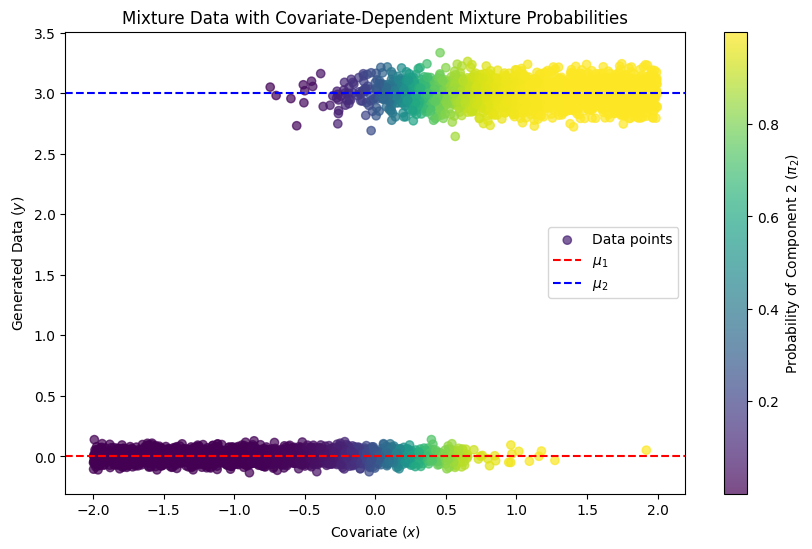

Epoch 10/100, Loss: 1.7456
Epoch 20/100, Loss: 1.6792
Epoch 30/100, Loss: 1.6155
Epoch 40/100, Loss: 1.5408
Epoch 50/100, Loss: 1.4379
Epoch 60/100, Loss: 1.3748
Epoch 70/100, Loss: 1.3276
Epoch 80/100, Loss: 1.3560
Epoch 90/100, Loss: 1.3334
Epoch 100/100, Loss: 1.3130
Posterior Mean (first 5): [1.32632055e-07 4.68607146e-05 2.07622880e+00 6.38339983e-05
 3.63655919e-09]
Posterior SD (first 5): [2.87361767e-04 7.00915273e-03 2.27463257e-01 7.91351204e-03
 4.09860287e-05]


In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
np.random.seed( 2)
n_samples = 5000
a, b = 5.0, -1.0  # Coefficients for logistic regression to control mixture probabilities
mu_1, sigma_1_sq = 0.0, 0.2
mu_2, sigma_2_sq = 3.0,  0.3

# Covariates
x = np.random.uniform(-2, 2, n_samples)

# Mixture probabilities
pi_2 = 1 / (1 + np.exp(-(a * x + b)))  # Sigmoid function for covariate-dependent pi_2
pi_1 = 1 - pi_2  # Ensure pi_1 + pi_2 = 1

# Generate data
y = np.zeros(n_samples)
betahat = np.zeros(n_samples)
c = np.zeros(n_samples, dtype=int)  # Ensure c is an integer array
for i in range(n_samples):
    # Use .item() to extract the scalar from np.random.choice
    c[i] = np.random.choice([0, 1], p=[pi_1[i], pi_2[i]])
    if c[i] == 0:
        y[i] = np.random.normal(mu_1,  sigma_1_sq **2)
        betahat[i]= y[i]+ np.random.normal(0,  0.5)
    else:
        y[i] = np.random.normal(mu_2,  sigma_2_sq   **2 )
        betahat[i]= y[i]+ np.random.normal(0,  0.5)

 
# Visualize the data
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=pi_2, cmap='viridis', label='Data points', alpha=0.7)
plt.colorbar(label='Probability of Component 2 ($\pi_2$)')
plt.axhline(mu_1, color='red', linestyle='--', label='$\mu_1$')
plt.axhline(mu_2, color='blue', linestyle='--', label='$\mu_2$')
plt.xlabel('Covariate ($x$)')
plt.ylabel('Generated Data ($y$)')
plt.title('Mixture Data with Covariate-Dependent Mixture Probabilities')
plt.legend()
plt.show()


# Data generation and visualization remain the same as in the previous code.
sebetahat =y*0+0.25
# Call the function
res = cgb_posterior_means(X=x, betahat=betahat, sebetahat=sebetahat, n_epochs=100, n_layers=2)

# Display results
print("Posterior Mean (first 5):", res.post_mean[:5])
print("Posterior SD (first 5):", res.post_sd[:5])

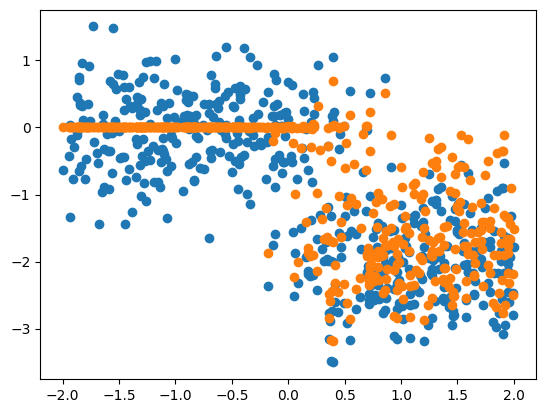

In [9]:
plt.scatter(x, betahat)
plt.scatter(x, res.post_mean)


In [10]:
res.sigma_2

np.float64(2.4579090432094284)

In [11]:
res.mu_2

4.587008476257324